In [49]:
import netCDF4
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline
# read provided netcdf
ncpath='../ncfiles/Ocean1_input_geom_v1.01.nc'
x = netCDF4.Dataset(ncpath).variables['x'][:]
y = netCDF4.Dataset(ncpath).variables['y'][:]
upperSurface = netCDF4.Dataset(ncpath).variables['upperSurface'][:]
lowerSurface = netCDF4.Dataset(ncpath).variables['lowerSurface'][:]
[X,Y]=np.meshgrid(x/1.0e3,y/1.0e3)

# read 3D file
file3D = netCDF4.Dataset('../ncfiles/Ocean1_3D.nc','r+')
# read 3D file
file2D = netCDF4.Dataset('../ncfiles/Ocean1_2D.nc','r+')

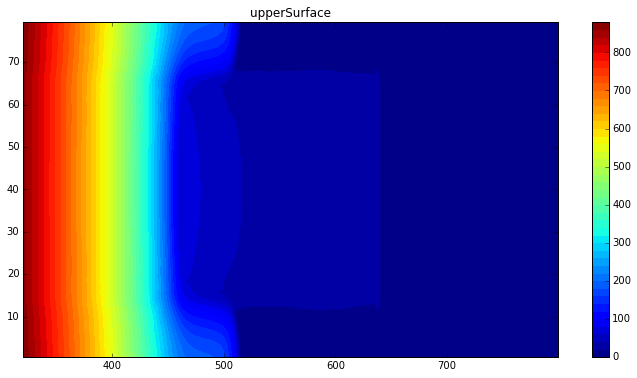

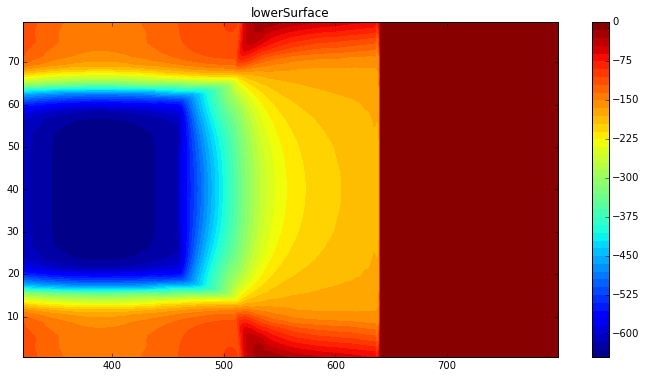

In [50]:
# original data
plt.figure(figsize=(12,6))
plt.contourf(X,Y,upperSurface,50)
plt.colorbar()
plt.title('upperSurface')
plt.figure(figsize=(12,6))
plt.contourf(X,Y,lowerSurface, 50)
plt.colorbar()
plt.title('lowerSurface')

In [51]:
# smoothing
thick_smoth = np.zeros(upperSurface.shape)
lowerSurface_smoth = np.zeros(lowerSurface.shape)
upperSurface_smoth = np.zeros(upperSurface.shape)

sigma = 2 #  the standard deviation of the distribution
lowerSurface_smoth = gaussian_filter(lowerSurface,sigma)
upperSurface_smoth = gaussian_filter(upperSurface,sigma)
thick = upperSurface_smoth - lowerSurface_smoth

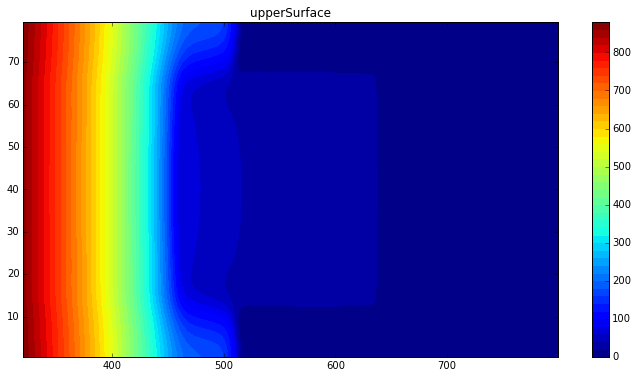

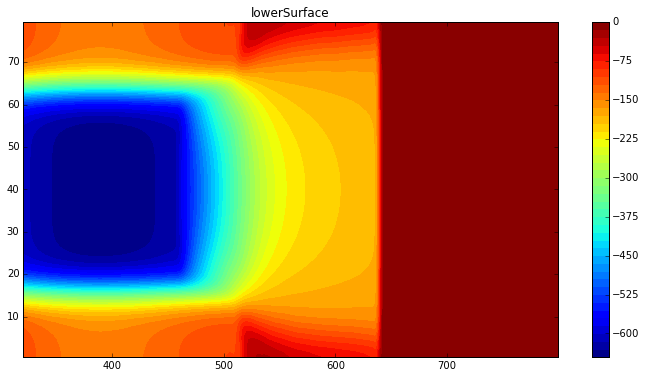

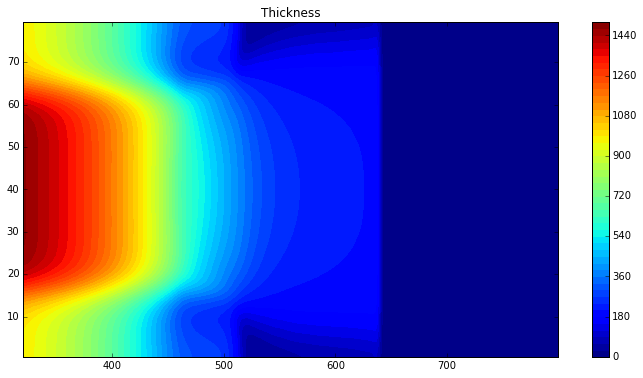

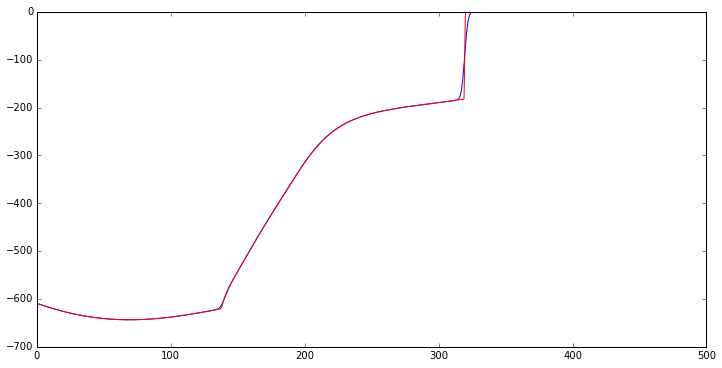

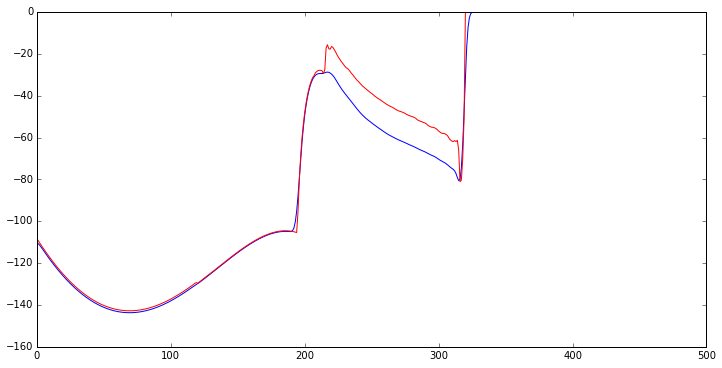

In [52]:
# smoothed data
plt.figure(figsize=(12,6))
plt.contourf(X,Y,upperSurface_smoth,50)
plt.colorbar()
plt.title('upperSurface')
plt.figure(figsize=(12,6))
plt.contourf(X,Y,lowerSurface_smoth, 50)
plt.colorbar()
plt.title('lowerSurface')
plt.figure(figsize=(12,6))
plt.contourf(X,Y,thick, 50)
plt.colorbar()
plt.title('Thickness')
plt.figure(figsize=(12,6))
plt.plot(lowerSurface_smoth[40,:],'b');plt.plot(lowerSurface[40,:],'r')
plt.figure(figsize=(12,6))
plt.plot(lowerSurface_smoth[0,:],'b');plt.plot(lowerSurface[0,:],'r')

In [53]:
# coarse grid
x1=x[::2];y1=y[::2]
thick1=thick[::2,::2]
height=lowerSurface_smoth[::2,::2]
area = np.ones((thick1.shape))* (x1[1]-x1[0]) * (y1[1]-y1[0])
area[thick1==0.0]=0.0

In [54]:
# put into netcdf files

# 3D
file3D.variables['area'][:,:] = area[:,:].T
file3D.variables['thick'][:,:] = thick1[:,:].T
file3D.variables['height'][:,:] = height[:,:].T

# 2D (middle of the domain)
for i in range(file2D.variables['area'].shape[1]):
    file2D.variables['area'][:,i] = area[20,:]
    file2D.variables['thick'][:,i] = thick1[20,:]
    file2D.variables['height'][:,i] = height[20,:] 

file2D.close()
file3D.close()